# Essentials

In [ ]:
! pip install -qq -U tensorflow-addons
! pip install --no-binary=h5py h5py

     |████████████████████████████████| 1.1 MB 14.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import math
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from keras.models import Model

SEED = 42
keras.utils.set_random_seed(SEED)

# Prepare the data

In [ ]:
NUM_CLASSES = 100
INPUT_SHAPE = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()


169001437/169001437 [==============================] - 12s 0us/step


(-0.5, 31.5, 31.5, -0.5)

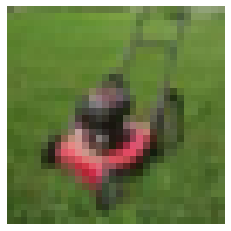

In [ ]:
# Visualize one sample

plt.imshow(x_train[500])
plt.axis("off")


In [ ]:
## Hyperparameters

# DATA
BUFFER_SIZE = 512
BATCH_SIZE = 256

# AUGMENTATION
IMAGE_SIZE = 72
PATCH_SIZE = 6
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2

# OPTIMIZER
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001   # L2 regularization

# TRAINING
EPOCHS = 70

# ARCHITECTURE
LAYER_NORM_EPS = 1e-6
TRANSFORMER_LAYERS = 8
STUDENT_LAYERS = 4
PROJECTION_DIM = 64
NUM_HEADS = 4
TRANSFORMER_UNITS = [
    PROJECTION_DIM * 2,
    PROJECTION_DIM,
]
STUDENT_UNITS = [
    PROJECTION_DIM,
    PROJECTION_DIM / 2,
]
MLP_HEAD_UNITS = [2048, 1024]

# Creating the ViT blocks

In [ ]:
## Augment the data

data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [ ]:
class ShiftedPatchTokenization(layers.Layer):
    def __init__(
        self,
        image_size=IMAGE_SIZE,
        patch_size=PATCH_SIZE,
        num_patches=NUM_PATCHES,
        projection_dim=PROJECTION_DIM,
        vanilla=False,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.vanilla = vanilla  # Flag to swtich to vanilla patch extractor
        self.image_size = image_size
        self.patch_size = patch_size
        self.half_patch = patch_size // 2
        self.flatten_patches = layers.Reshape((num_patches, -1))
        self.projection = layers.Dense(units=projection_dim)
        self.layer_norm = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)

    def get_config(self):
        config = super().get_config()
        config.update({
            "image_size": self.image_size,
            "patch_size": self.patch_size,
            "projection": self.projection,
            "vanilla": self.vanilla,
            "half_patch": self.half_patch,
            "flatten_patches": self.flatten_patches,
            "layer_norm": self.layer_norm,
        })
        return config


    def crop_shift_pad(self, images, mode):
        # Build the diagonally shifted images
        if mode == "left-up":
            crop_height = self.half_patch
            crop_width = self.half_patch
            shift_height = 0
            shift_width = 0
        elif mode == "left-down":
            crop_height = 0
            crop_width = self.half_patch
            shift_height = self.half_patch
            shift_width = 0
        elif mode == "right-up":
            crop_height = self.half_patch
            crop_width = 0
            shift_height = 0
            shift_width = self.half_patch
        else:
            crop_height = 0
            crop_width = 0
            shift_height = self.half_patch
            shift_width = self.half_patch

        # Crop the shifted images and pad them
        crop = tf.image.crop_to_bounding_box(
            images,
            offset_height=crop_height,
            offset_width=crop_width,
            target_height=self.image_size - self.half_patch,
            target_width=self.image_size - self.half_patch,
        )
        shift_pad = tf.image.pad_to_bounding_box(
            crop,
            offset_height=shift_height,
            offset_width=shift_width,
            target_height=self.image_size,
            target_width=self.image_size,
        )
        return shift_pad

    def call(self, images):
        if not self.vanilla:
            # Concat the shifted images with the original image
            images = tf.concat(
                [
                    images,
                    self.crop_shift_pad(images, mode="left-up"),
                    self.crop_shift_pad(images, mode="left-down"),
                    self.crop_shift_pad(images, mode="right-up"),
                    self.crop_shift_pad(images, mode="right-down"),
                ],
                axis=-1,
            )
        # Patchify the images and flatten it
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        flat_patches = self.flatten_patches(patches)
        if not self.vanilla:
            # Layer normalize the flat patches and linearly project it
            tokens = self.layer_norm(flat_patches)
            tokens = self.projection(tokens)
        else:
            # Linearly project the flat patches
            tokens = self.projection(flat_patches)
        return (tokens, patches)


## Visualization of shifted patches

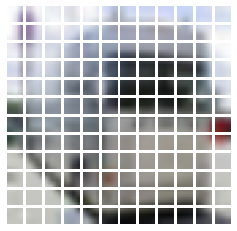

ORIGINAL


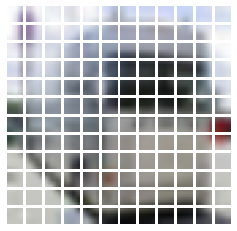

LEFT-UP


LEFT-DOWN


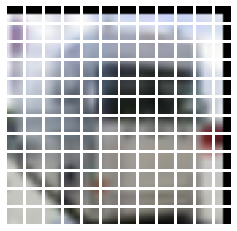

RIGHT-UP


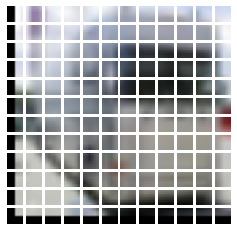

RIGHT-DOWN


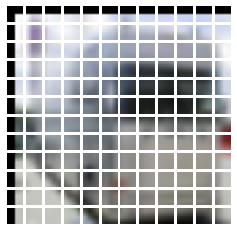

In [ ]:
# Get a random image from the training dataset
# and resize the image
image = x_train[np.random.choice(range(x_train.shape[0]))]
resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(IMAGE_SIZE, IMAGE_SIZE)
)

# Vanilla patch maker: This takes an image and divides into
# patches as in the original ViT paper
(token, patch) = ShiftedPatchTokenization(vanilla=True)(resized_image / 255.0)
(token, patch) = (token[0], patch[0])
n = patch.shape[0]
count = 1
plt.figure(figsize=(4, 4))
for row in range(n):
    for col in range(n):
        plt.subplot(n, n, count)
        count = count + 1
        image = tf.reshape(patch[row][col], (PATCH_SIZE, PATCH_SIZE, 3))
        plt.imshow(image)
        plt.axis("off")
plt.show()

# Shifted Patch Tokenization: This layer takes the image, shifts it
# diagonally and then extracts patches from the concatinated images
(token, patch) = ShiftedPatchTokenization(vanilla=False)(resized_image / 255.0)
(token, patch) = (token[0], patch[0])
n = patch.shape[0]
shifted_images = ["ORIGINAL", "LEFT-UP", "LEFT-DOWN", "RIGHT-UP", "RIGHT-DOWN"]
for index, name in enumerate(shifted_images):
    print(name)
    count = 1
    plt.figure(figsize=(4, 4))
    for row in range(n):
        for col in range(n):
            plt.subplot(n, n, count)
            count = count + 1
            image = tf.reshape(patch[row][col], (PATCH_SIZE, PATCH_SIZE, 5 * 3))
            plt.imshow(image[..., 3 * index : 3 * index + 3])
            plt.axis("off")
    plt.show()

In [ ]:
# Add positional embeddings to coded patches

class PatchEncoder(layers.Layer):
    def __init__(
        self, num_patches=NUM_PATCHES, projection_dim=PROJECTION_DIM, **kwargs
    ):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
        self.positions = tf.range(start=0, limit=self.num_patches, delta=1)

    def get_config(self):
        config = super().get_config()
        config.update({
            "num_patches": self.num_patches,
            "position_embedding": self.position_embedding,
            "positions": self.positions.numpy(),
        })
        return config

    def call(self, encoded_patches):
        encoded_positions = self.position_embedding(self.positions)
        encoded_patches = encoded_patches + encoded_positions
        return encoded_patches

## Locality Self Attention

In [ ]:
# Locality Self Attention

class MultiHeadAttentionLSA(tf.keras.layers.MultiHeadAttention):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # The trainable temperature term. The initial value is
        # the square root of the key dimension.
        self.tau = tf.Variable(math.sqrt(float(self._key_dim)), trainable=True)

    def get_config(self):
        config = super().get_config()
        config.update({
            "tau": self.tau.numpy(),
        })
        return config

    def _compute_attention(self, query, key, value, attention_mask=None, training=None):
        query = tf.multiply(query, 1.0 / self.tau)
        attention_scores = tf.einsum(self._dot_product_equation, key, query)
        attention_scores_soften = self._masked_softmax(attention_scores, attention_mask)
        attention_scores_dropout = self._dropout_layer(
            attention_scores_soften, training=training
        )
        attention_output = tf.einsum(
            self._combine_equation, attention_scores_dropout, value
        )
        return attention_output, attention_scores


## FFN

In [ ]:
# MLP

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


# Build the diagonal attention mask
diag_attn_mask = 1 - tf.eye(NUM_PATCHES)
diag_attn_mask = tf.cast([diag_attn_mask], dtype=tf.int8)

## Create the ViT model

In [ ]:

def create_vit_classifier(number_of_layers=TRANSFORMER_LAYERS, vanilla=False, hidd_units=TRANSFORMER_UNITS):
    inputs = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    # Create patches.
    (tokens, _) = ShiftedPatchTokenization(vanilla=vanilla)(inputs)
    # Encode patches.
    encoded_patches = PatchEncoder()(tokens)

    # Create multiple layers of the Transformer block.
    for _ in range(number_of_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        if not vanilla:
            attention_output, scores = MultiHeadAttentionLSA(
                num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=0.1
            )(x1, x1, attention_mask=diag_attn_mask, return_attention_scores=True)
        else:
            attention_output = layers.MultiHeadAttention(
                num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=0.1
            )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=hidd_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=MLP_HEAD_UNITS, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(NUM_CLASSES)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

## Compile, train and evaluate

In [ ]:
# Some code is taken from:
# https://www.kaggle.com/ashusma/training-rfcx-tensorflow-tpu-effnet-b2.
class WarmUpCosine(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super(WarmUpCosine, self).__init__()

        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")

        cos_annealed_lr = tf.cos(
            self.pi
            * (tf.cast(step, tf.float32) - self.warmup_steps)
            / float(self.total_steps - self.warmup_steps)
        )
        learning_rate = 0.5 * self.learning_rate_base * (1 + cos_annealed_lr)

        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )

In [ ]:
def run_experiment(model):
    total_steps = int((len(x_train) / BATCH_SIZE) * EPOCHS)
    warmup_epoch_percentage = 0.10
    warmup_steps = int(total_steps * warmup_epoch_percentage)
    scheduled_lrs = WarmUpCosine(
        learning_rate_base=LEARNING_RATE,
        total_steps=total_steps,
        warmup_learning_rate=0.0,
        warmup_steps=warmup_steps,
    )

    optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    history = model.fit(
        x=data_augmentation(x_train),
        y=y_train,
        batch_size=BATCH_SIZE,
        epochs=50,
        validation_split=0.1,
    )
    _, accuracy, top_5_accuracy = model.evaluate(data_augmentation(x_test), y_test, batch_size=BATCH_SIZE)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history

In [ ]:
# Create ViT with the Shifted Patch Tokenization and
# Locality Self Attention modified
vit_sl = create_vit_classifier(vanilla=False)

vit_sl.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 72, 72, 3)]  0           []                               
                                                                                                  
 shifted_patch_tokenization_2 (  ((None, 144, 64),   35704       ['input_1[0][0]']                
 ShiftedPatchTokenization)       (None, 12, 12, 540                                               
                                ))                                                                
                                                                                                  
 patch_encoder (PatchEncoder)   (None, 144, 64)      9216        ['shifted_patch_tokenization_2[0]
                                                                 [0]']                        

In [ ]:
# Run experiments with the vanilla ViT

history = run_experiment(vit_sl)

Epoch 1/50
176/176 [==============================] - 80s 397ms/step - loss: 4.4826 - accuracy: 0.0446 - top-5-accuracy: 0.1563 - val_loss: 3.9205 - val_accuracy: 0.1114 - val_top-5-accuracy: 0.3172
Epoch 2/50
176/176 [==============================] - 69s 393ms/step - loss: 3.9423 - accuracy: 0.0999 - top-5-accuracy: 0.2934 - val_loss: 3.5726 - val_accuracy: 0.1684 - val_top-5-accuracy: 0.4060
Epoch 3/50
176/176 [==============================] - 70s 396ms/step - loss: 3.6612 - accuracy: 0.1432 - top-5-accuracy: 0.3731 - val_loss: 3.3275 - val_accuracy: 0.2120 - val_top-5-accuracy: 0.4718
Epoch 4/50
176/176 [==============================] - 70s 399ms/step - loss: 3.4628 - accuracy: 0.1773 - top-5-accuracy: 0.4324 - val_loss: 3.2036 - val_accuracy: 0.2282 - val_top-5-accuracy: 0.5132
Epoch 5/50
176/176 [==============================] - 71s 401ms/step - loss: 3.2622 - accuracy: 0.2090 - top-5-accuracy: 0.4820 - val_loss: 2.9962 - val_accuracy: 0.2634 - val_top-5-accuracy: 0.5632
Epoch

## Visualization of results

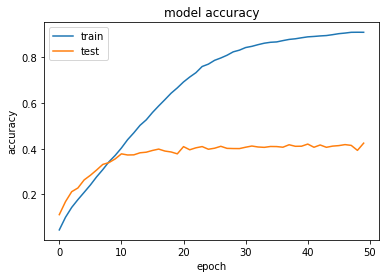

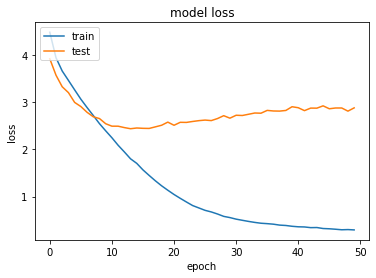

In [ ]:
# summarize history for accuracy


plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Saving and loading the model

In [ ]:
# Save model
vit_sl.save_weights('vit_weights.h5')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
vit_sl.save_weights('/content/drive/MyDrive/Colab Notebooks/vit_weights.h5')

# Attention Based Distillation

In [ ]:
vit_loaded = create_vit_classifier(vanilla=False)

In [ ]:
vit_loaded.load_weights('/content/drive/MyDrive/Colab Notebooks/vit_weights.h5')

In [ ]:
# Distillation

DISTILL_EPOCHS = 50

## Defining the distiller

In [ ]:
class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        """ Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature
        self.att_t0 = Model(inputs=self.teacher.input,
                      outputs=self.teacher.get_layer(index=4).output[1])
        self.att_t1 = Model(inputs=self.teacher.input,
                      outputs=self.teacher.get_layer(index=22).output[1])
        self.att_t2 = Model(inputs=self.teacher.input,
                      outputs=self.teacher.get_layer(index=49).output[1])
        self.att_t3 = Model(inputs=self.teacher.input,
                      outputs=self.teacher.get_layer(index=67).output[1])
        self.att_s0 = Model(inputs=self.student.input,
                      outputs=self.student.get_layer(index=4).output[1])
        self.att_s1 = Model(inputs=self.student.input,
                      outputs=self.student.get_layer(index=13).output[1])
        self.att_s2 = Model(inputs=self.student.input,
                      outputs=self.student.get_layer(index=22).output[1])
        self.att_s3 = Model(inputs=self.student.input,
                      outputs=self.student.get_layer(index=31).output[1])

    def train_step(self, data):
        # Unpack data
        x, y = data
        x_augmented = data_augmentation(x)

        # Teacher attention representation to be distilled
        # The mapping between teacher and student layers is supossed to be
        # 2m -> n , where m is the teacher layer and n is the student layer
        # but we priorize the prediction layer of the teacher to be mapped to
        # prediction layer of the student
        # Therefore MultiHeadAttention sublayers to be considered are 0, 2, 5 and 7
        # 0 being the first MultiAttention sublayer

        scores_t0 = self.att_t0(x_augmented, training=False)
        scores_t1 = self.att_t1(x_augmented, training=False)
        scores_t2 = self.att_t2(x_augmented, training=False)
        scores_t3 = self.att_t3(x_augmented, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x_augmented, training=True)

            # Attention maps from student
            scores_s0 = self.att_s0(x_augmented, training=True)
            scores_s1 = self.att_s1(x_augmented, training=True)
            scores_s2 = self.att_s2(x_augmented, training=True)
            scores_s3 = self.att_s3(x_augmented, training=True)


            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)


            # Distillation loss is based on attention maps as proposed in https://arxiv.org/abs/1909.10351
            # While they distill a NLP Encoder-Decoder transformer, here we distill
            # a ViT into a smaller one

            attention_loss = (
                (
                    self.distillation_loss_fn(
                        scores_t0[:,0,:,:],
                        scores_s0[:,0,:,:],
                    ) + self.distillation_loss_fn(
                        scores_t0[:,1,:,:],
                        scores_s0[:,1,:,:],
                    ) + self.distillation_loss_fn(
                        scores_t0[:,2,:,:],
                        scores_s0[:,2,:,:],
                    ) + self.distillation_loss_fn(
                        scores_t0[:,3,:,:],
                        scores_s0[:,3,:,:],
                    ) + self.distillation_loss_fn(
                        scores_t1[:,0,:,:],
                        scores_s1[:,0,:,:],
                    ) + self.distillation_loss_fn(
                        scores_t1[:,1,:,:],
                        scores_s1[:,1,:,:],
                    ) + self.distillation_loss_fn(
                        scores_t1[:,2,:,:],
                        scores_s1[:,2,:,:],
                    ) + self.distillation_loss_fn(
                        scores_t1[:,3,:,:],
                        scores_s1[:,3,:,:],
                    ) + self.distillation_loss_fn(
                        scores_t2[:,0,:,:],
                        scores_s2[:,0,:,:],
                    ) + self.distillation_loss_fn(
                        scores_t2[:,1,:,:],
                        scores_s2[:,1,:,:],
                    ) + self.distillation_loss_fn(
                        scores_t2[:,2,:,:],
                        scores_s2[:,2,:,:],
                    ) + self.distillation_loss_fn(
                        scores_t2[:,3,:,:],
                        scores_s2[:,3,:,:],
                    ) + self.distillation_loss_fn(
                        scores_t3[:,0,:,:],
                        scores_s3[:,0,:,:],
                    ) + self.distillation_loss_fn(
                        scores_t3[:,1,:,:],
                        scores_s3[:,1,:,:],
                    ) + self.distillation_loss_fn(
                        scores_t3[:,2,:,:],
                        scores_s3[:,2,:,:],
                    ) + self.distillation_loss_fn(
                        scores_t3[:,3,:,:],
                        scores_s3[:,3,:,:],
                    )
                )
                / (NUM_HEADS * STUDENT_LAYERS)
            )

            loss = self.alpha * student_loss + (1 - self.alpha) * attention_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": attention_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data
        x_augmented = data_augmentation(x)

        # Compute predictions
        y_prediction = self.student(x_augmented, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results


## Distilling ViT

In [ ]:
# Create the student
student1 = create_vit_classifier(number_of_layers=STUDENT_LAYERS, vanilla=False)

student1.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 72, 72, 3)]  0           []                               
                                                                                                  
 shifted_patch_tokenization_3 (  ((None, 144, 64),   35704       ['input_2[0][0]']                
 ShiftedPatchTokenization)       (None, 12, 12, 540                                               
                                ))                                                                
                                                                                                  
 patch_encoder_1 (PatchEncoder)  (None, 144, 64)     9216        ['shifted_patch_tokenization_3[0]
                                                                 [0]']                      

In [ ]:
# Initialize and compile distiller
distiller = Distiller(student=student1, teacher=vit_loaded)
distiller.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=tf.keras.losses.MeanSquaredError(),
    alpha=0.5,
    temperature=10,
)

# Distill teacher to student
history = distiller.fit(x_train, y_train, epochs=DISTILL_EPOCHS, batch_size=BATCH_SIZE)

# Evaluate student on test dataset

_, accuracy, top_5_accuracy = distiller.evaluate(x_test, y_test)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

Epoch 1/50
196/196 [==============================] - 180s 820ms/step - accuracy: 0.0606 - top-5-accuracy: 0.1947 - student_loss: 4.3579 - distillation_loss: 0.9084
Epoch 2/50
196/196 [==============================] - 165s 844ms/step - accuracy: 0.1471 - top-5-accuracy: 0.3811 - student_loss: 3.6433 - distillation_loss: 0.2907
Epoch 3/50
196/196 [==============================] - 168s 857ms/step - accuracy: 0.2068 - top-5-accuracy: 0.4866 - student_loss: 3.2550 - distillation_loss: 0.2506
Epoch 4/50
196/196 [==============================] - 168s 858ms/step - accuracy: 0.2546 - top-5-accuracy: 0.5491 - student_loss: 3.0012 - distillation_loss: 0.2268
Epoch 5/50
196/196 [==============================] - 168s 858ms/step - accuracy: 0.2884 - top-5-accuracy: 0.5973 - student_loss: 2.8088 - distillation_loss: 0.2137
Epoch 6/50
196/196 [==============================] - 168s 857ms/step - accuracy: 0.3215 - top-5-accuracy: 0.6337 - student_loss: 2.6477 - distillation_loss: 0.2053
Epoch 7/50

## Saving results

In [ ]:
student1.save_weights('/content/drive/MyDrive/transf/vit_student1.h5')

In [ ]:
np.save('/content/drive/MyDrive/transf/student1_history.npy',history.history)

In [ ]:
student1_sl = create_vit_classifier(number_of_layers=STUDENT_LAYERS, vanilla=False, STUDENT_UNITS)

In [ ]:
history = run_experiment(student1_sl)

## Visualizing the distillation

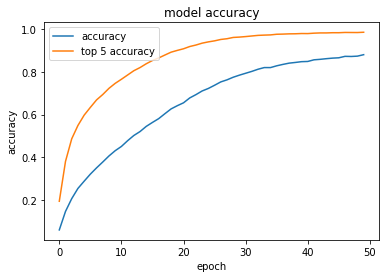

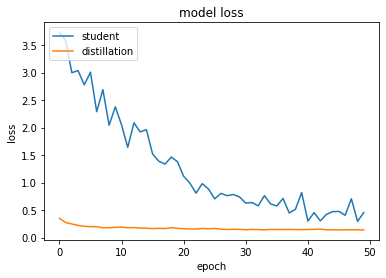

In [ ]:
# summarize history for accuracy


plt.plot(history.history['accuracy'])
plt.plot(history.history['top-5-accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'top 5 accuracy'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['student_loss'])
plt.plot(history.history['distillation_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['student', 'distillation'], loc='upper left')
plt.show()